# Dependencies and files

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests
import utils.cluster_visualisation as vis

from scipy.cluster.hierarchy import average, leaves_list
from scipy.spatial.distance import pdist

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
figures_dir = f'human_specific_genes/figures/'
os.makedirs(figures_dir, exist_ok=True)

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [5]:
specie_palette = {
    "human": "tab:red",
    "chimp": "tab:orange",
    "macaque": "tab:green"
}

## Load files

In [6]:
pb_dir_path = 'data/pseudobulks/'

In [7]:
os.listdir(pb_dir_path)

['pb_age.h5ad',
 'pb_chimp.h5ad',
 'pb_human.h5ad',
 'pb_macaque.h5ad',
 'pb_mammals.h5ad',
 'pb_spatial_libd_human.h5ad',
 'pseudobulk_all_four.h5ad',
 'pseudobulk_all_mammals.h5ad',
 'pseudobulk_humans.h5ad']

In [8]:
adata_pb = sc.read_h5ad(pb_dir_path + 'pseudobulk_all_mammals.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 89 × 9209
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'X_pca_mean_norm', 'condition_colors', 'layer_colors', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_mean_norm'
    varm: 'PCs', 'X_pca_mean_norm'
    layers: 'counts', 'mean_norm', 'psbulk_props'

## Differential expression results

In [9]:
from statsmodels.stats.multitest import multipletests
import pandas as pd
res_dict = dict()
res_dict['human-chimp'] = pd.read_csv('data/human_specific_genes/edgeR_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('data/human_specific_genes/edgeR_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('data/human_specific_genes/edgeR_chimp_macaque.csv', index_col=0)

for key, df in res_dict.items():
    mult_test = multipletests(df['PValue'], method='fdr_bh')
    df['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

,logFC.spline_1.human,logFC.spline_2.human,logFC.spline_3.human,logCPM,F,PValue,p_val_adj
DUSP18,0.016419,-0.408164,-0.076850,8.732532,0.599835,0.621445,1.000000
NUP133,-0.120152,-0.177927,0.152832,8.887767,0.802623,0.496042,0.956481
FRY,0.042341,0.430236,0.144912,9.310594,0.730499,0.536246,0.969740
SNAP29,-0.267528,-0.543385,0.226842,8.831206,2.844384,0.044300,0.334603
ECI2,-0.506797,-0.154881,0.250713,8.786108,2.113979,0.111451,0.532374


In [10]:
sign_genes = lambda df, pval: df[df.p_val_adj < pval].index
sign_genes_dict = {key:sign_genes(df, 0.05) for key, df in res_dict.items()}
sign_genes_dict['chimp-macaque'] = sign_genes(res_dict['chimp-macaque'], 0.2)
sign_genes_dict

{'human-chimp': Index(['EPHA7', 'CAPRIN1', 'ERC1', 'APBA1', 'TMCC2', 'LDHB', 'ANK3', 'ROBO2',
        'CRIM1', 'SPOCK1',
        ...
        'CAMLG', 'MRPL51', 'AMZ2', 'HPCAL4', 'ALCAM', 'SNAP25', 'RAP2A',
        'PHYHIP', 'TMEM59L', 'ELAVL4'],
       dtype='object', length=261),
 'human-macaque': Index(['LRRC4', 'DNAJC19', 'PAPSS2', 'PACS2', 'ZNF277', 'PARK7', 'GATAD1',
        'EFHD2', 'IDH2', 'ZDHHC9',
        ...
        'CSDE1', 'ANKFY1', 'ATP6V1B2', 'SPATS2L', 'AKR1B1', 'HMGA1', 'KLHL4',
        'EMC10', 'SLC37A1', 'ELAVL4'],
       dtype='object', length=1852),
 'chimp-macaque': Index(['DNAJC19', 'EFHD2', 'IDH2', 'ZDHHC9', 'SLC23A2', 'COPRS', 'FAAP100',
        'MEST', 'CFL2', 'GALC',
        ...
        'SLA', 'ZNF536', 'SPATS2L', 'CHD4', 'AKR1B1', 'HMGA1', 'LEMD3', 'P4HB',
        'ELAVL4', 'HMGCR'],
       dtype='object', length=1588)}

Let's define Human-specific genes as $(HC\bigcap HM)\setminus CM$

In [11]:
hs_genes = sign_genes_dict['human-chimp'].intersection(sign_genes_dict['human-macaque']).difference(sign_genes_dict['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ALCAM', 'AMZ2', 'ASAH1', 'ATP1A3', 'ATP5MG', 'ATP6V1G1', 'BOLA3',
        'BRK1', 'CCSER2', 'CD47', 'CHST10', 'CKB', 'CLSTN1', 'CX3CL1', 'DCXR',
        'DLGAP4', 'ECSIT', 'EIF1B', 'EIF4G3', 'EPHB6', 'ERC1', 'ETFB', 'FBXO9',
        'GDE1', 'GNAZ', 'GSTO1', 'HSPE1', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21',
        'KLHL2', 'LCMT1', 'LHX2', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51',
        'NDUFB10', 'NHP2', 'NPM1', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4',
        'PDE1A', 'PES1', 'PSMB7', 'PTPRK', 'RALYL', 'RBIS', 'RGS2', 'RIMS4',
        'SCD5', 'SCN3B', 'SEPTIN6', 'SNRPD2', 'SULF2', 'SYNGAP1', 'TCEAL4',
        'TMED3', 'TRIR', 'UBA1', 'UBE2V1', 'VAT1L', 'YWHAE', 'ZBTB18',
        'ZBTB46'],
       dtype='object'),
 69)

In [12]:
background_genes = res_dict['human-chimp'].index.tolist()
len(background_genes)

7801

In [13]:
with open('data/human_specific_genes/background_genes.txt', 'w', newline='') as f:
    writer = f.write(','.join(background_genes))

# Clusterisation

In [14]:
df = pd.DataFrame(adata_pb.layers["mean_norm"], index=adata_pb.obs_names, columns=adata_pb.var_names)

In [15]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes].copy()

## Hierarchial

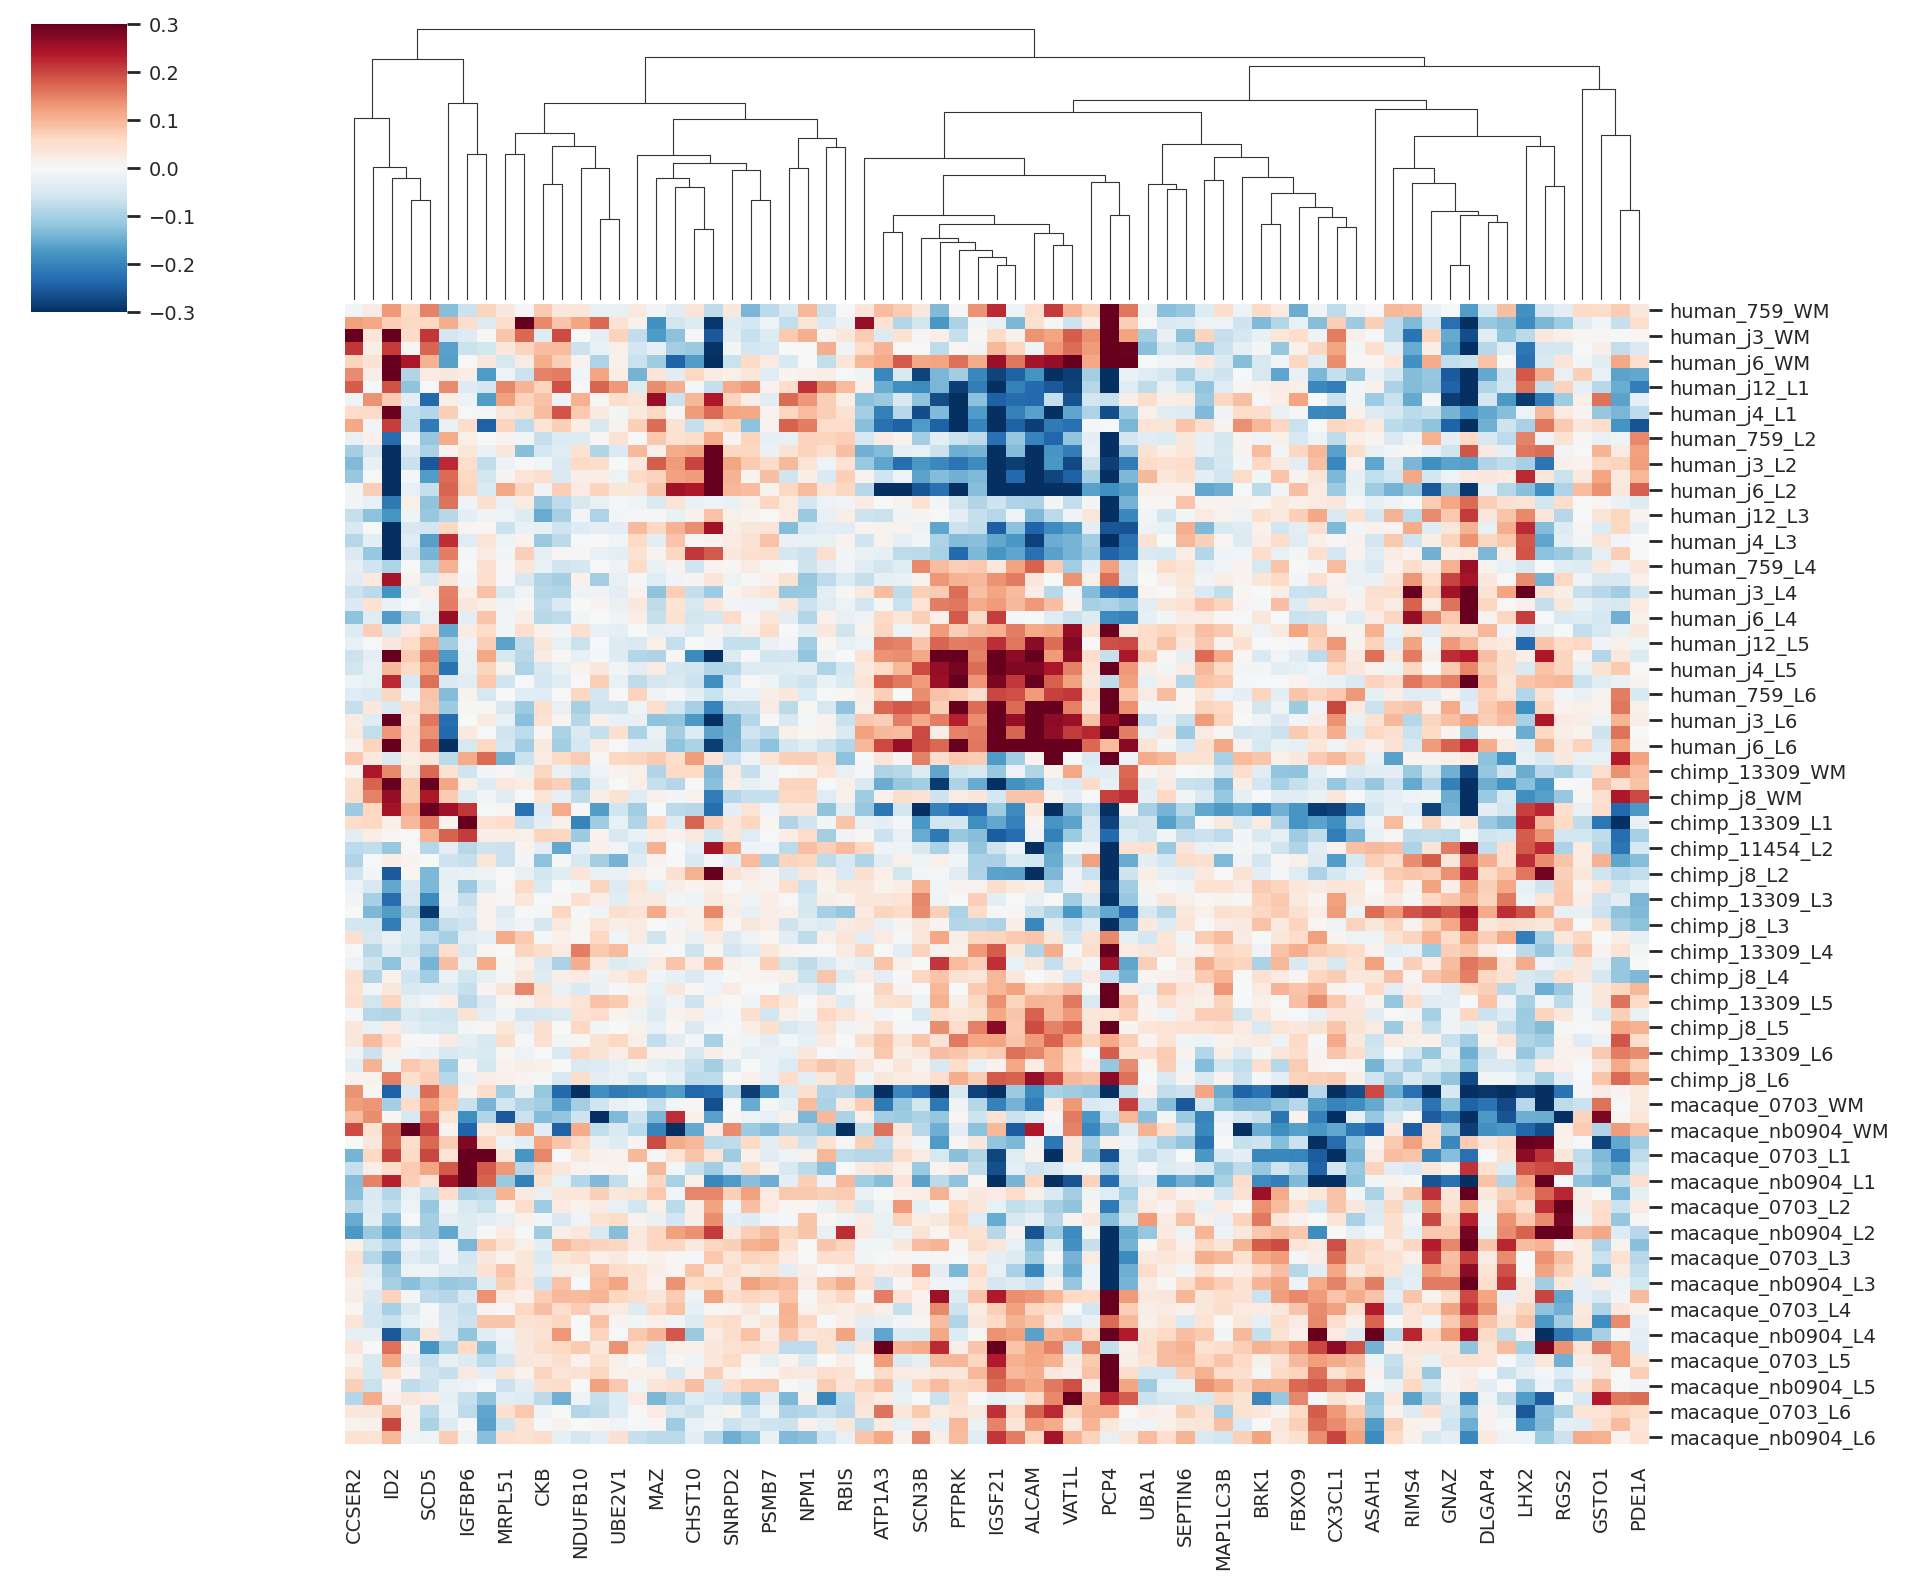

In [16]:
sns.set(font_scale=0.8)
cluster_grid = sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

<Axes: >

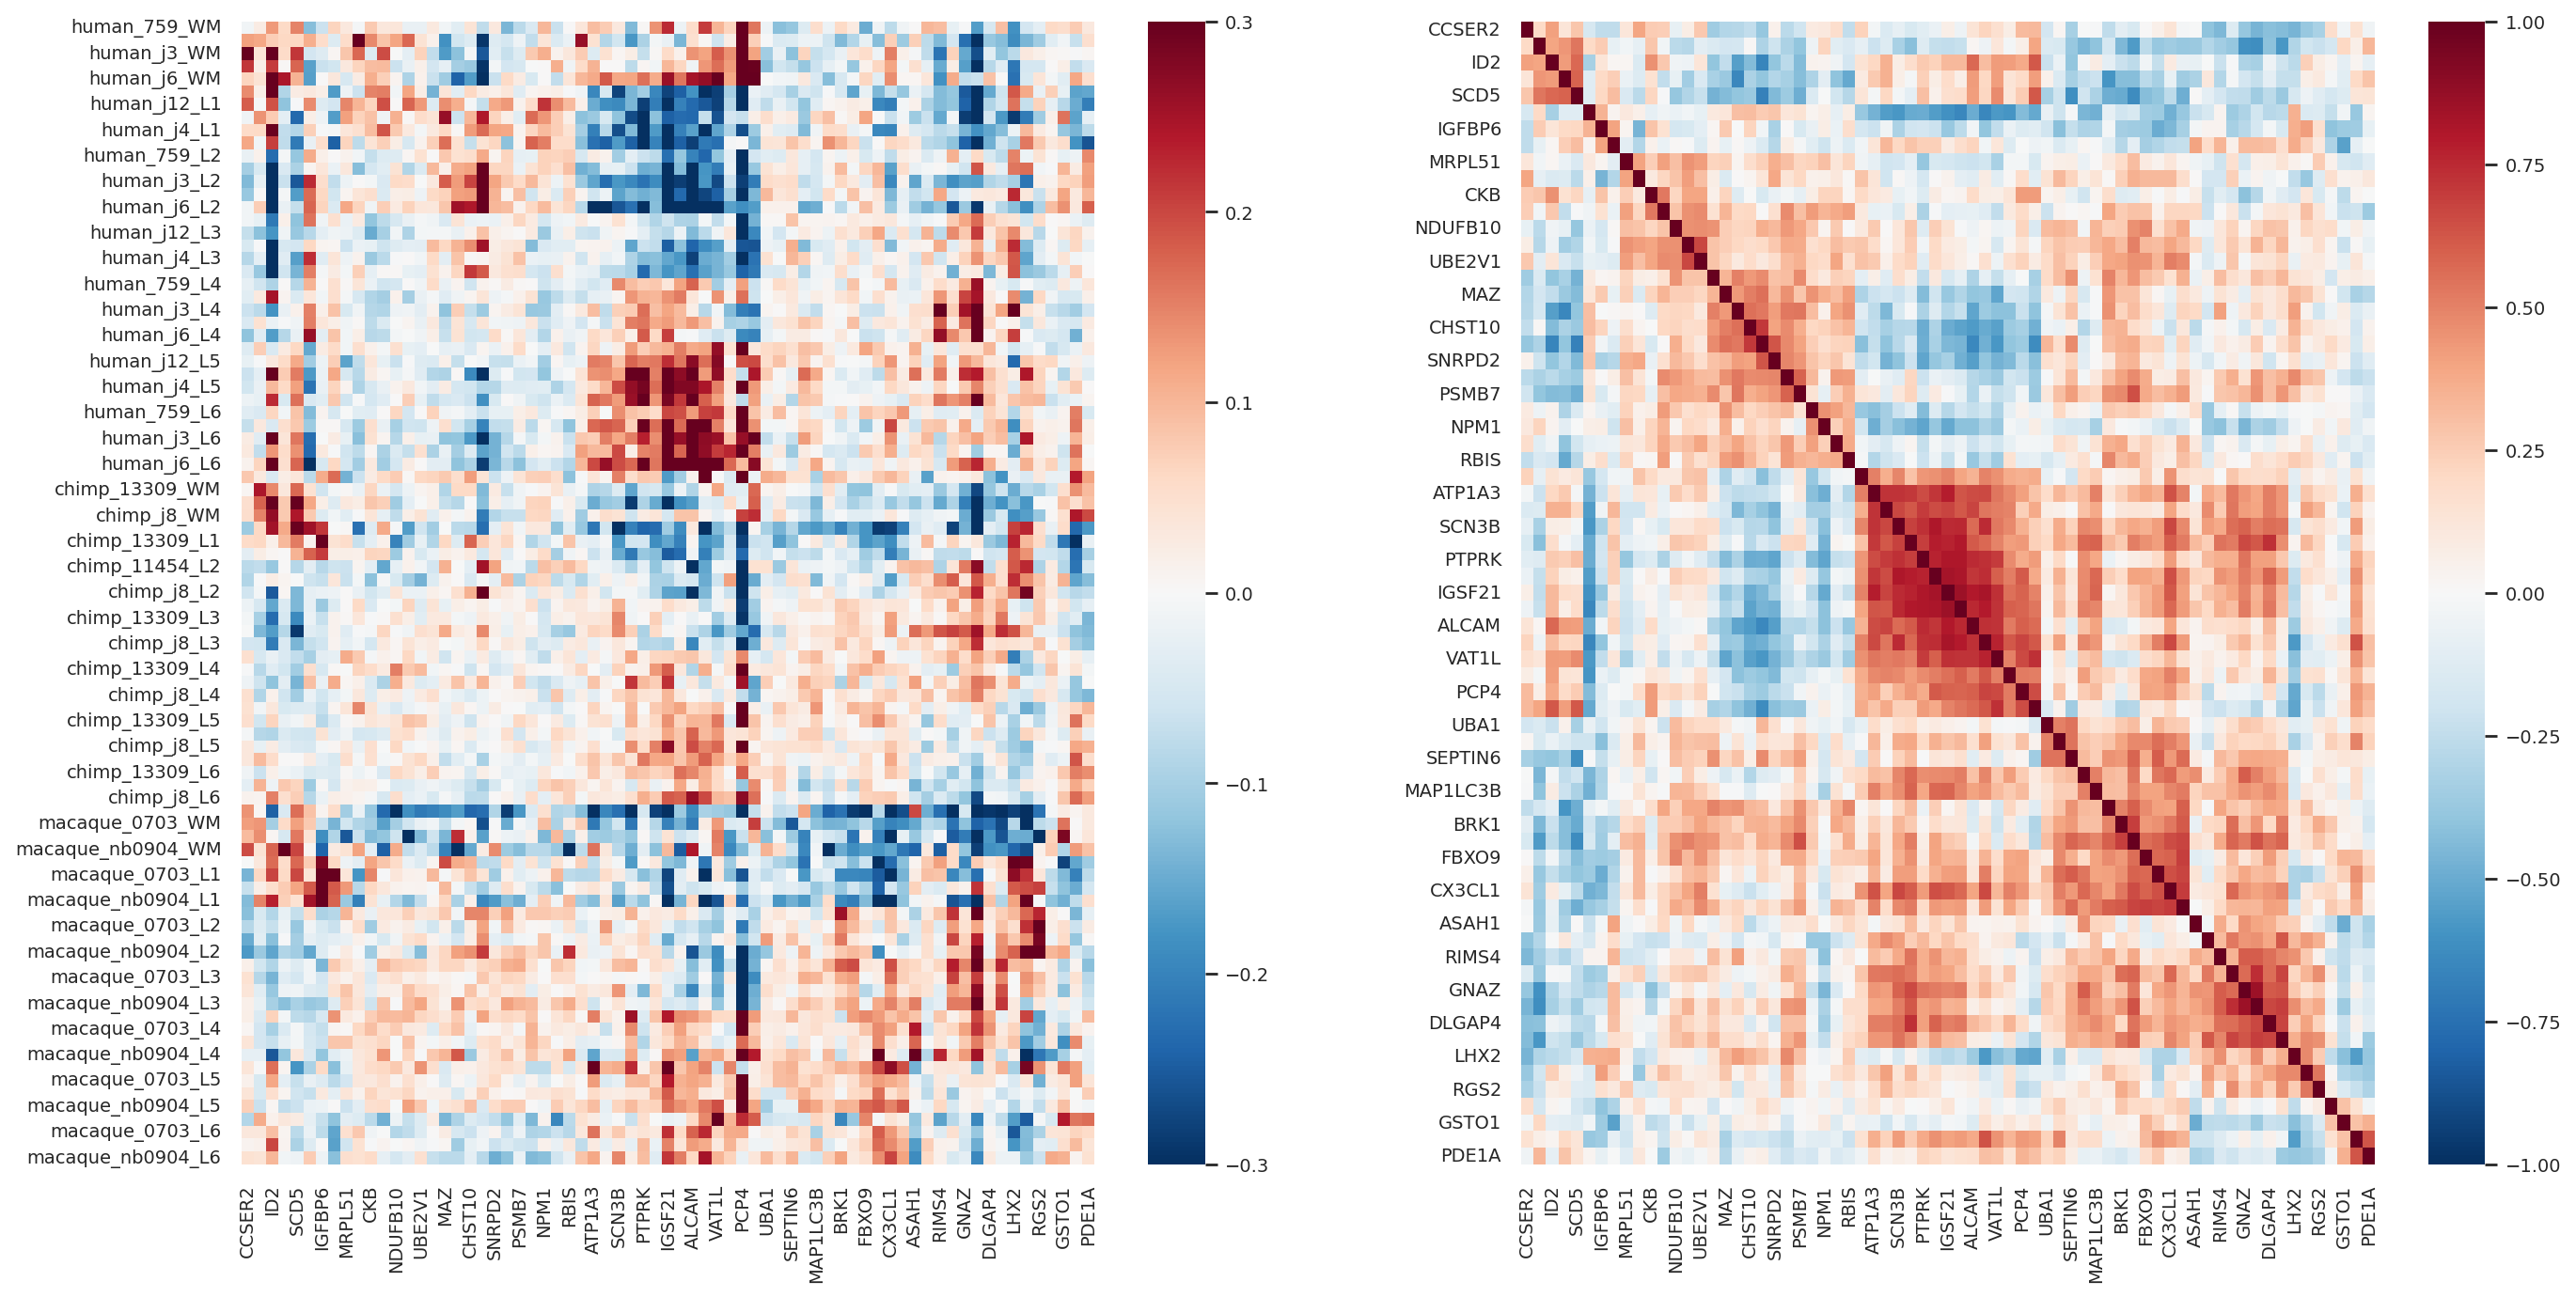

In [17]:
from sklearn.metrics.pairwise import pairwise_kernels
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

gene_order = df_hs.columns[cluster_grid.dendrogram_col.reordered_ind]
sns.heatmap(df_hs[gene_order], cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0, cbar=True, ax=ax[0])

aff_matrix = pairwise_kernels(df_hs.T, metric='cosine')
aff_df = pd.DataFrame(aff_matrix, index=df_hs.columns, columns=df_hs.columns)
sns.heatmap(aff_df.loc[gene_order, gene_order], cmap="RdBu_r", center=0, cbar=True, ax=ax[1], vmin=-1, vmax=1)

## Spectral clusterisation

In [18]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
#aff_matrix = (pairwise_kernels(df_hs.T, metric='cosine') + 1) / 2
n_clusters = 7
clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=4)
#clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=4, assign_labels='cluster_qr')
#clustering.fit(aff_matrix)
#clustering.fit(df_hs.T[sample_order['human']])
clustering.fit(df_hs.T)

,n_clusters,7
,eigen_solver,None
,n_components,None
,random_state,4
,n_init,10
,gamma,1.0
,affinity,'nearest_neighbors'
,n_neighbors,10
,eigen_tol,'auto'
,assign_labels,'kmeans'
,degree,3


In [19]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [20]:
labels.to_csv(f'data/human_specific_genes/human_clusters_edgeR_{n_clusters}.csv')

In [21]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown', 'cyan', 'pink', 'violet', 'crimson']

In [22]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

Sort clusters with hierarchical clustering

In [23]:
max_order = []
for label in range(n_clusters):
    genes = labels[labels == label].index
    linkage = average(pdist(df_hs[genes].T.values, 'cosine'))
    ind_order = leaves_list(linkage)
    gene_order = genes[ind_order]
    max_order += gene_order.to_list()

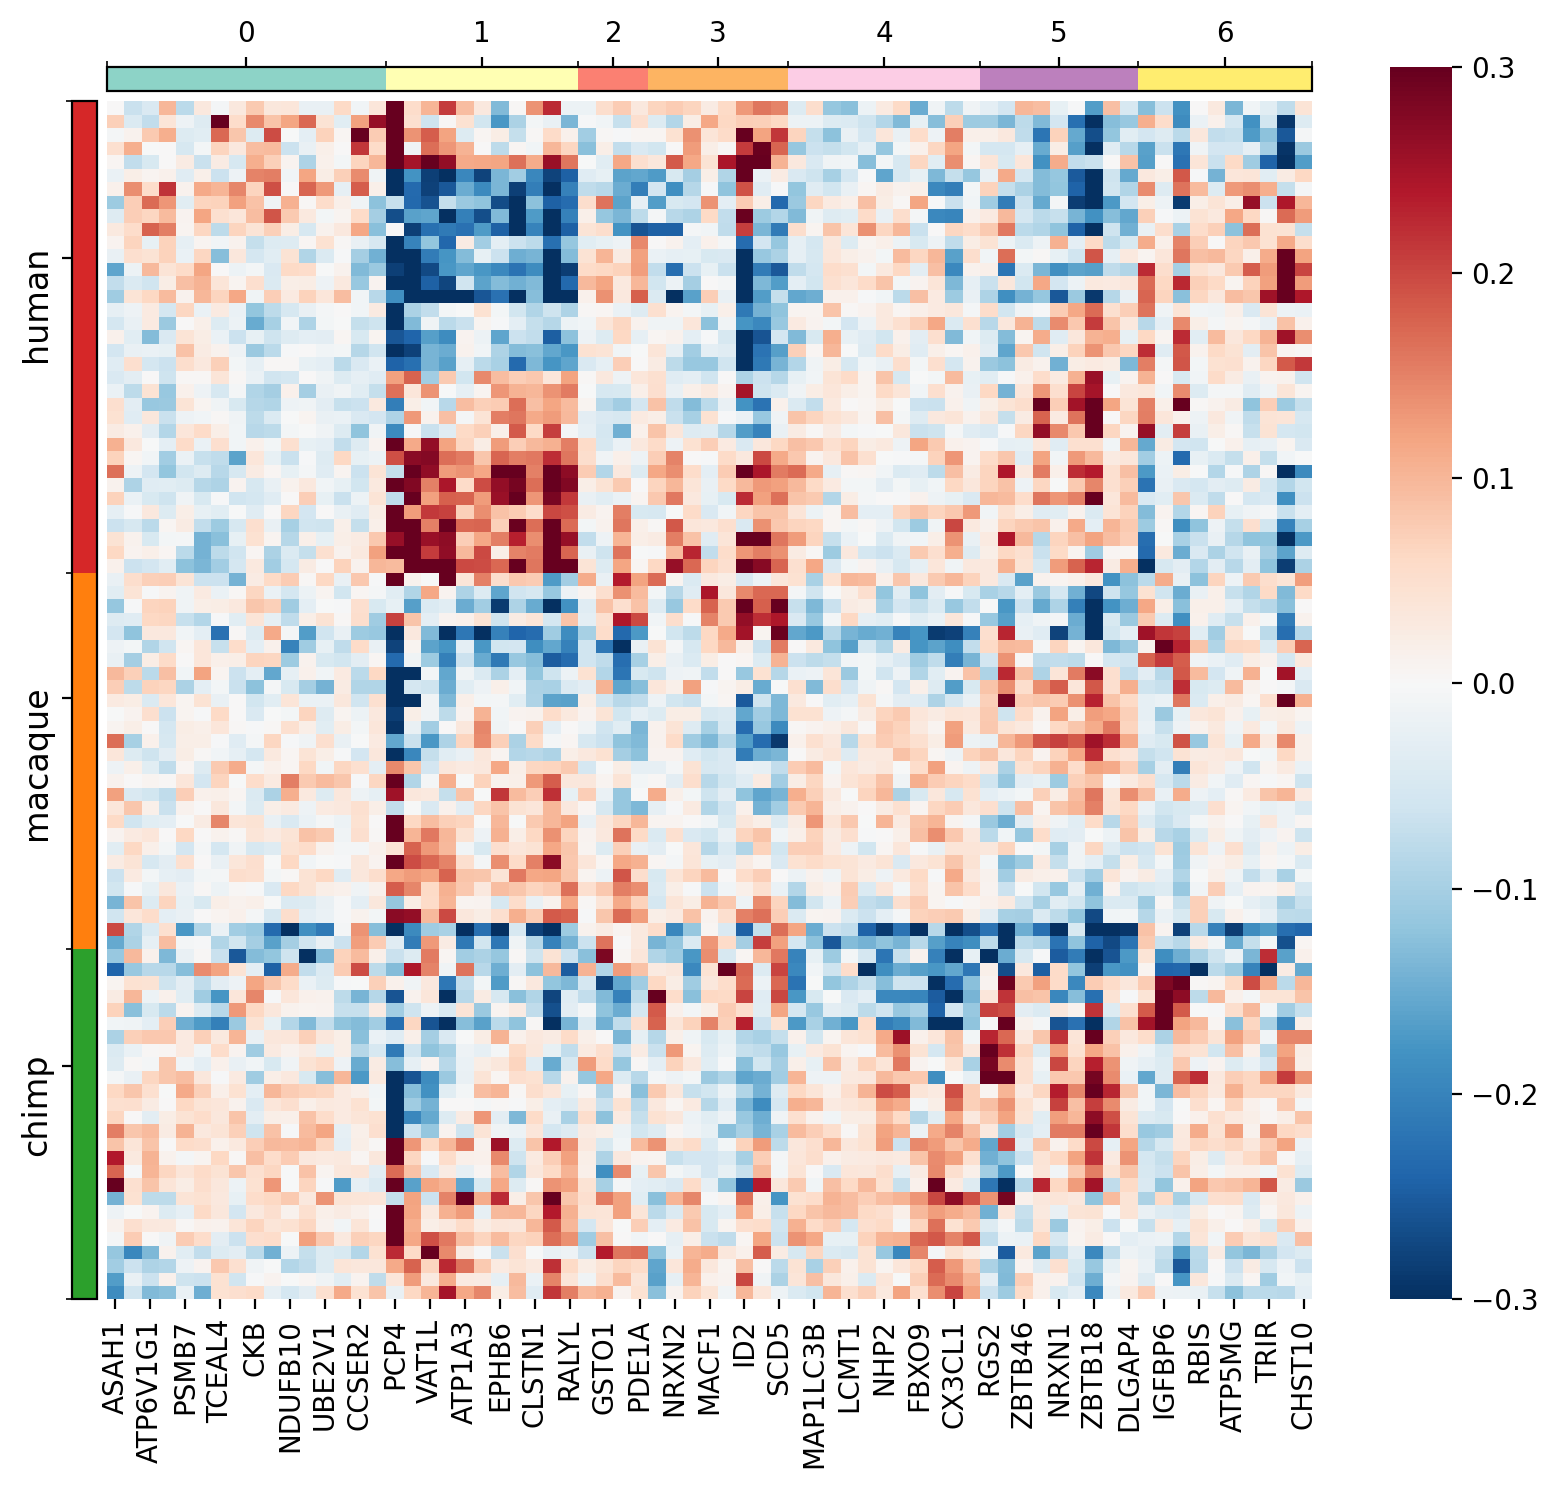

In [24]:
vis.plot_cluster_heatmap(
    df_hs,
    max_order,
    labels,
    adata_pb.obs.condition,
    clusters,
    cluster_cmap="Set3",
    cond_palette=specie_palette,
    figsize=(10, 8),
    vmax=0.3,
    vmin=-0.3,
    center=0,
    ax=None,
)
plt.savefig(f'{figures_dir}/human_specific_genes_clusters.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/human_specific_genes_clusters.pdf', bbox_inches='tight')

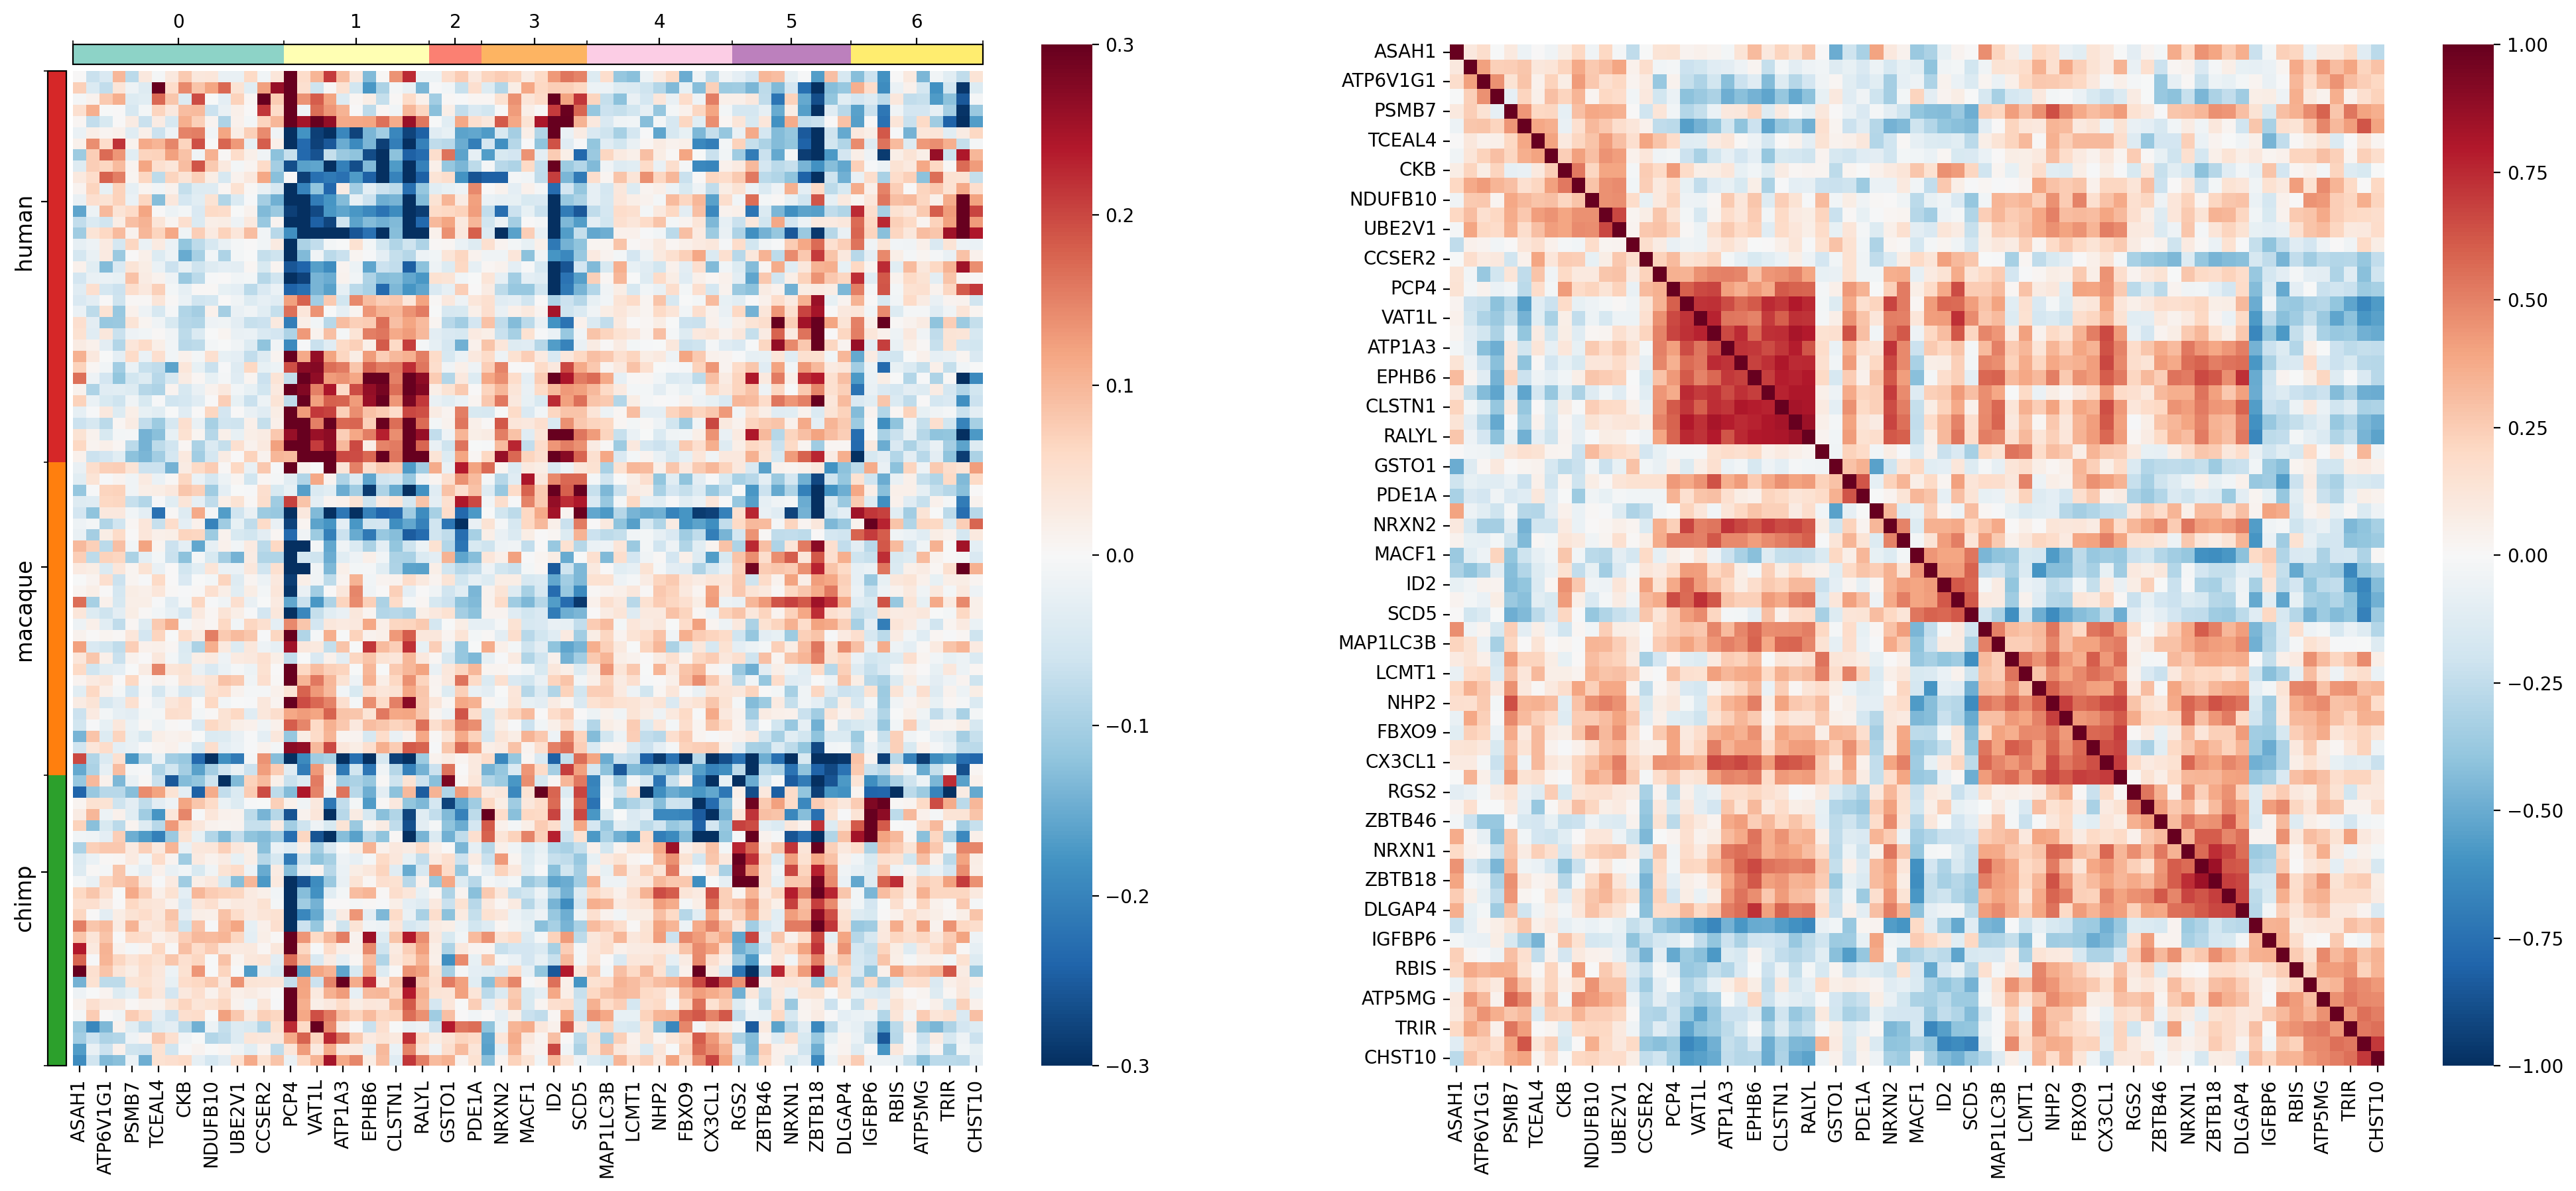

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

vis.plot_cluster_heatmap(
    df_hs,
    max_order,
    labels,
    adata_pb.obs.condition,
    clusters,
    cluster_cmap="Set3",
    cond_palette=specie_palette,
    figsize=(10, 8),
    vmax=0.3,
    vmin=-0.3,
    center=0,
    ax=ax1,
    fig=fig,
)

aff_matrix = pairwise_kernels(df_hs.T, metric='cosine')
sns.heatmap(aff_df.loc[max_order, max_order], cmap="RdBu_r", center=0, cbar=True, ax=ax2, vmin=-1, vmax=1)

plt.savefig(f'{figures_dir}/human_specific_genes_clusters_correlations.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/human_specific_genes_clusters_correlations.pdf', bbox_inches='tight')

## Visualise average profiles

### Simple average profiles

In [26]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb.obs.layer
df_annotation['condition'] = adata_pb.obs.condition

In [27]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ALCAM      AMZ2     ASAH1    ATP1A3    ATP5MG  ATP6V1G1  \
condition layer                                                               
chimp     L1     0.009140 -0.052386 -0.031841 -0.103851  0.023128 -0.011858   
          L2    -0.242811  0.028603  0.066111 -0.009618  0.034995 -0.017507   
          L3    -0.066339  0.001266  0.052338  0.021985  0.002132  0.000891   
          L4     0.006241  0.053422  0.038812  0.020152 -0.009501 -0.015771   
          L5     0.134402 -0.010463  0.015533  0.037400  0.015177 -0.007523   

                    BOLA3      BRK1    CCSER2      CD47  ...   SYNGAP1  \
condition layer                                          ...             
chimp     L1    -0.077460 -0.074095 -0.027430 -0.244314  ... -0.081345   
          L2     0.005049 -0.034559 -0.076836 -0.146557  ...  0.062635   
          L3    -0.027131  0.074569 -0.020517 -0.050846  ...  0.136532   
          L4     0.014207 -0.014958  0.018997  0.021575  ...  0.048600   
          L5     0.017914  0.007970  0.031268  0.104345  ... -0.052729   

                   TCEAL4     TMED3      TRIR      UBA1    UBE2V1     VAT1L  \
condition layer                                                               
chimp     L1    -0.091448  0.020570 -0.036310 -0.073059 -0.043984 -0.134590   
          L2    -0.007726 -0.013723  0.016355  0.010940 -0.057337 -0.027989   
          L3     0.020278 -0.001668  0.007358 -0.005550 -0.001068 -0.090567   
          L4     0.049120  0.015196  0.016500  0.015441  0.017594 -0.019784   
          L5     0.020757 -0.015035  0.009306  0.008177  0.021524  0.138455   

                    YWHAE    ZBTB18    ZBTB46  
condition layer                                
chimp     L1    -0.043810 -0.154319  0.026113  
          L2     0.006889  0.229186  0.072880  
          L3     0.031784  0.178190  0.070534  
          L4     0.006778  0.129220  0.024282  
          L5     0.007203  0.023012 -0.064329  

[5 rows x 69 columns]

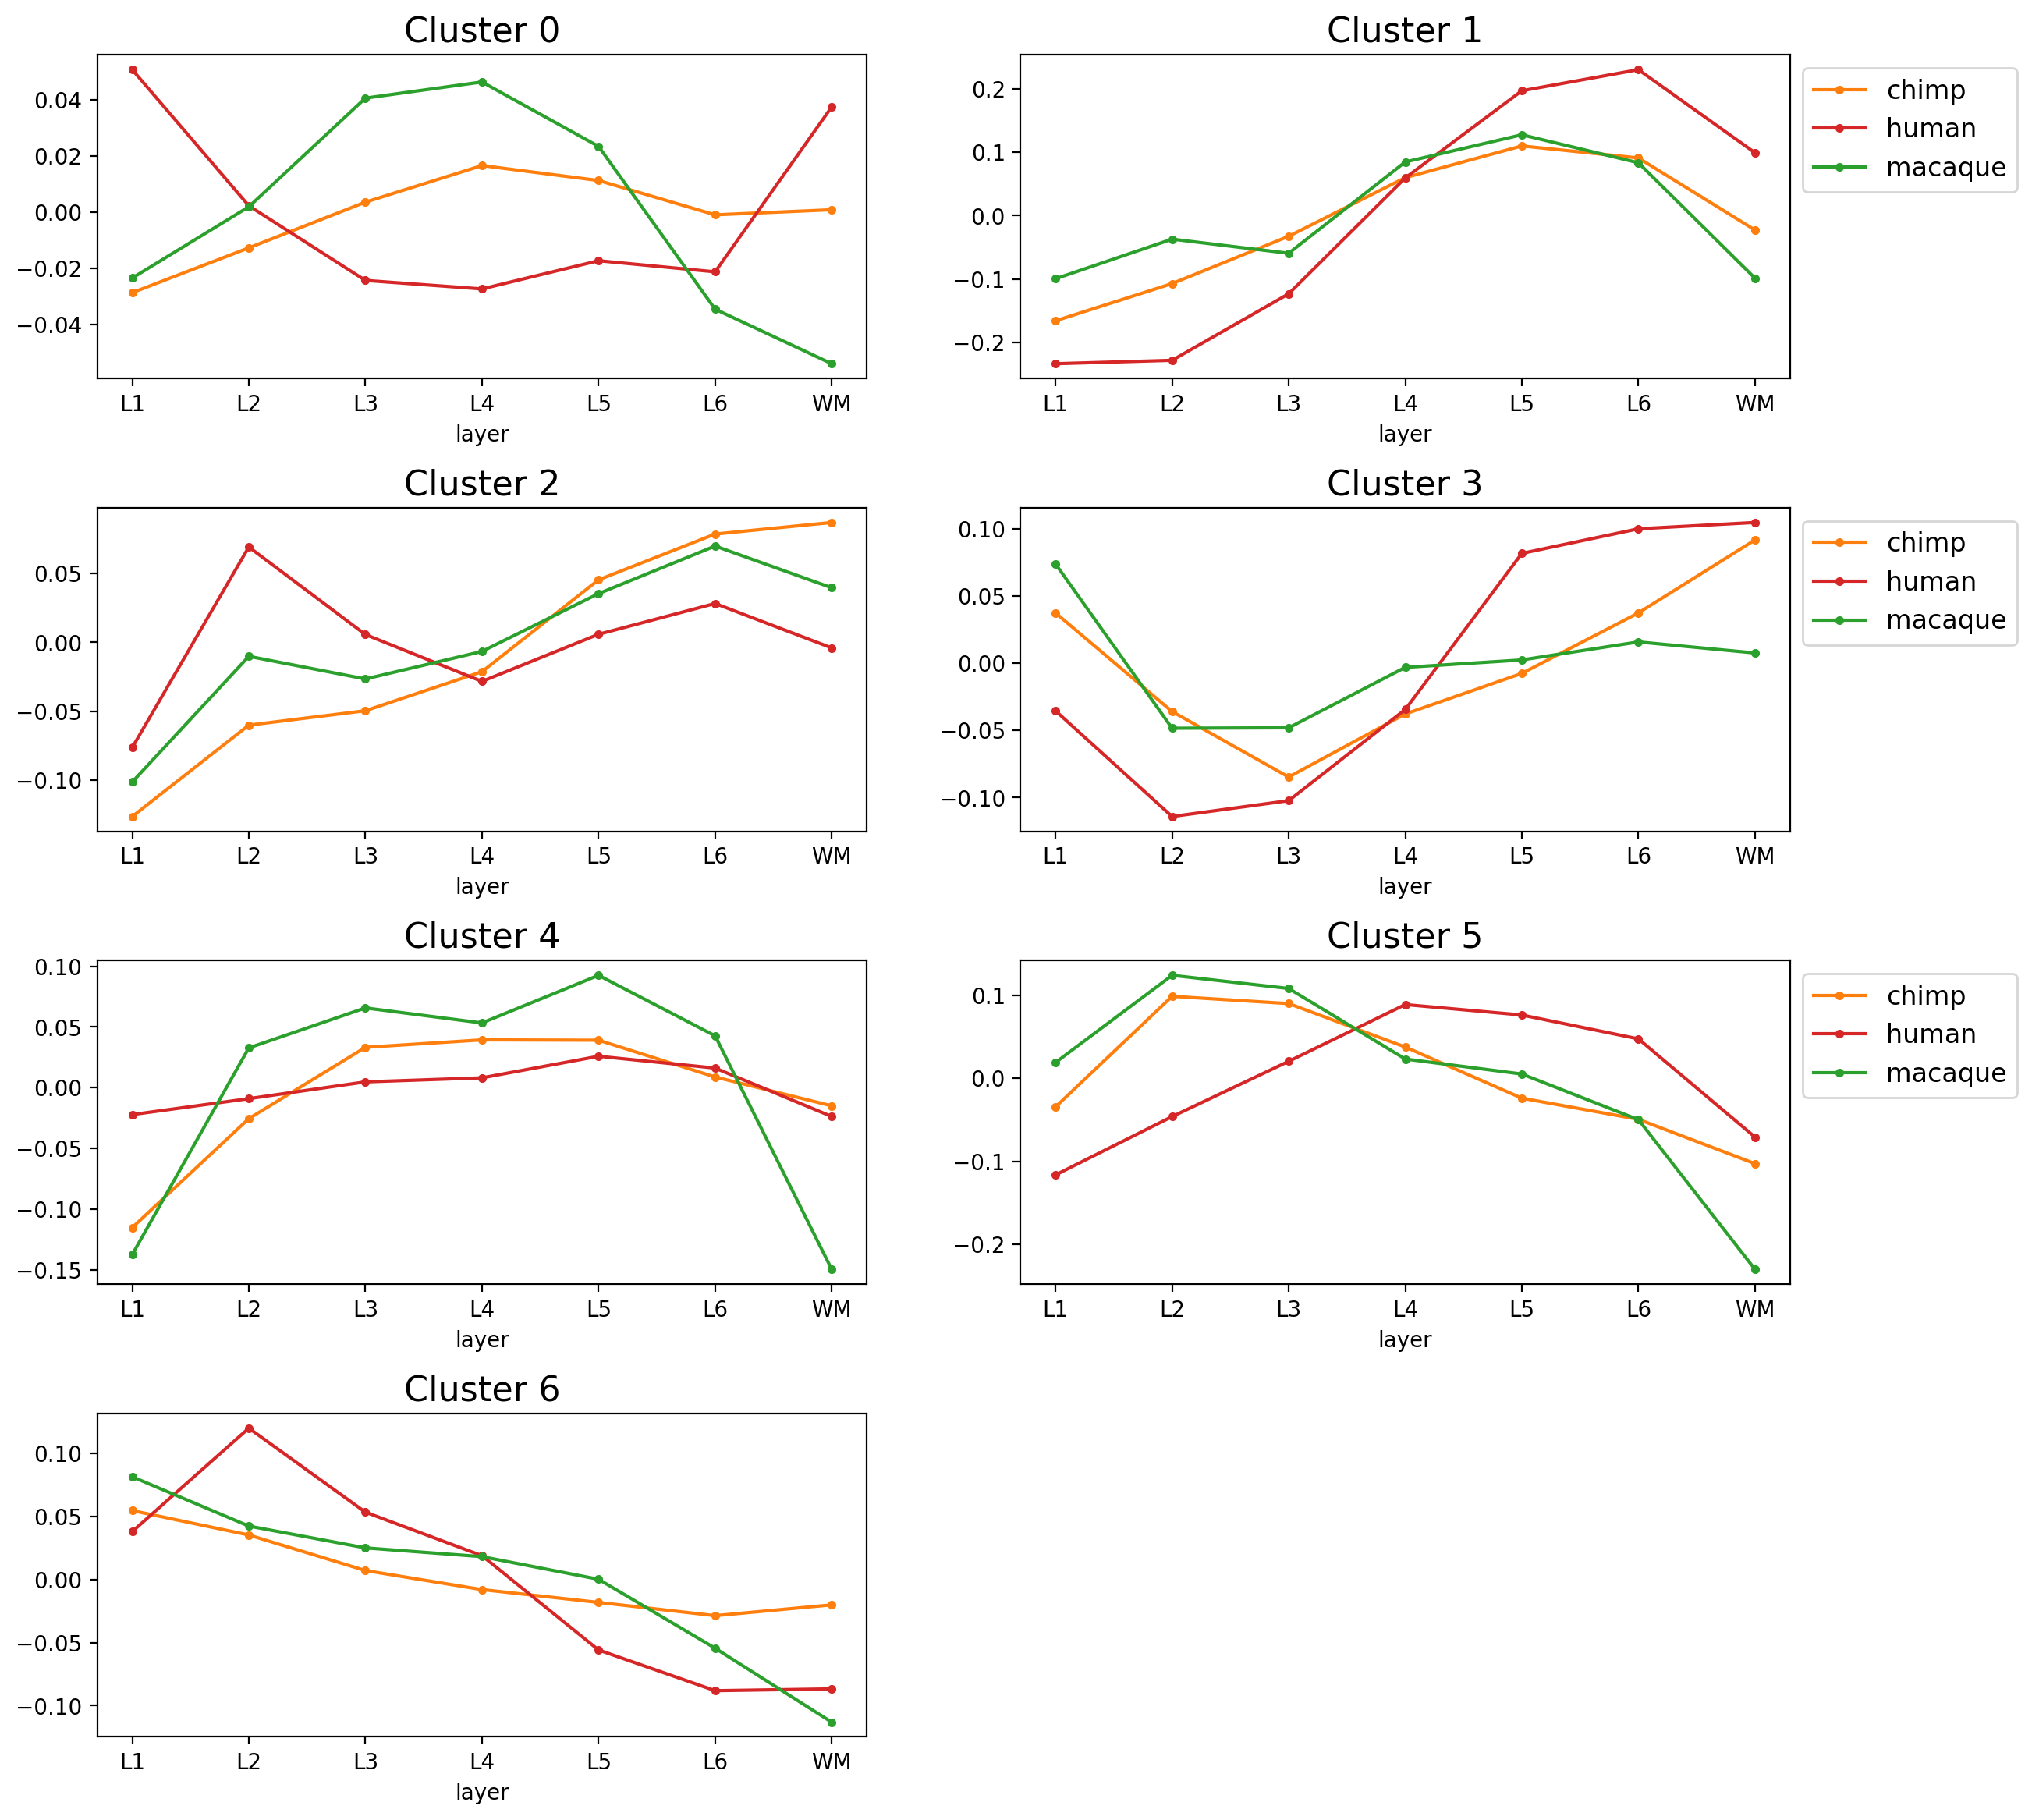

In [28]:
vis.plot_cluster_profiles(
    layer_mean,
    labels,
    layers,
    specie_palette,
    n_clusters=None,
    figsize=(14, None),
    hspace=0.4,
    marker=".",
    title_prefix="Cluster ",
)

plt.savefig(f'{figures_dir}/human_specific_genes_profiles.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/human_specific_genes_profiles.pdf', bbox_inches='tight')
plt.show()

### Approximate with splines

In [29]:
grid = np.linspace(1, 7, 400)
conditions = ['human', 'chimp', 'macaque']
cond_colors = ['tab:red', 'tab:orange', 'tab:green']

In [30]:
df_cont = df_annotation.copy()
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)

In [31]:
from scipy.interpolate import UnivariateSpline

array = np.zeros((grid.size, hs_genes.size))
df_list = []

for specie in conditions:
    for i, gene in enumerate(hs_genes.to_list()):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=hs_genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline = pd.concat(df_list)

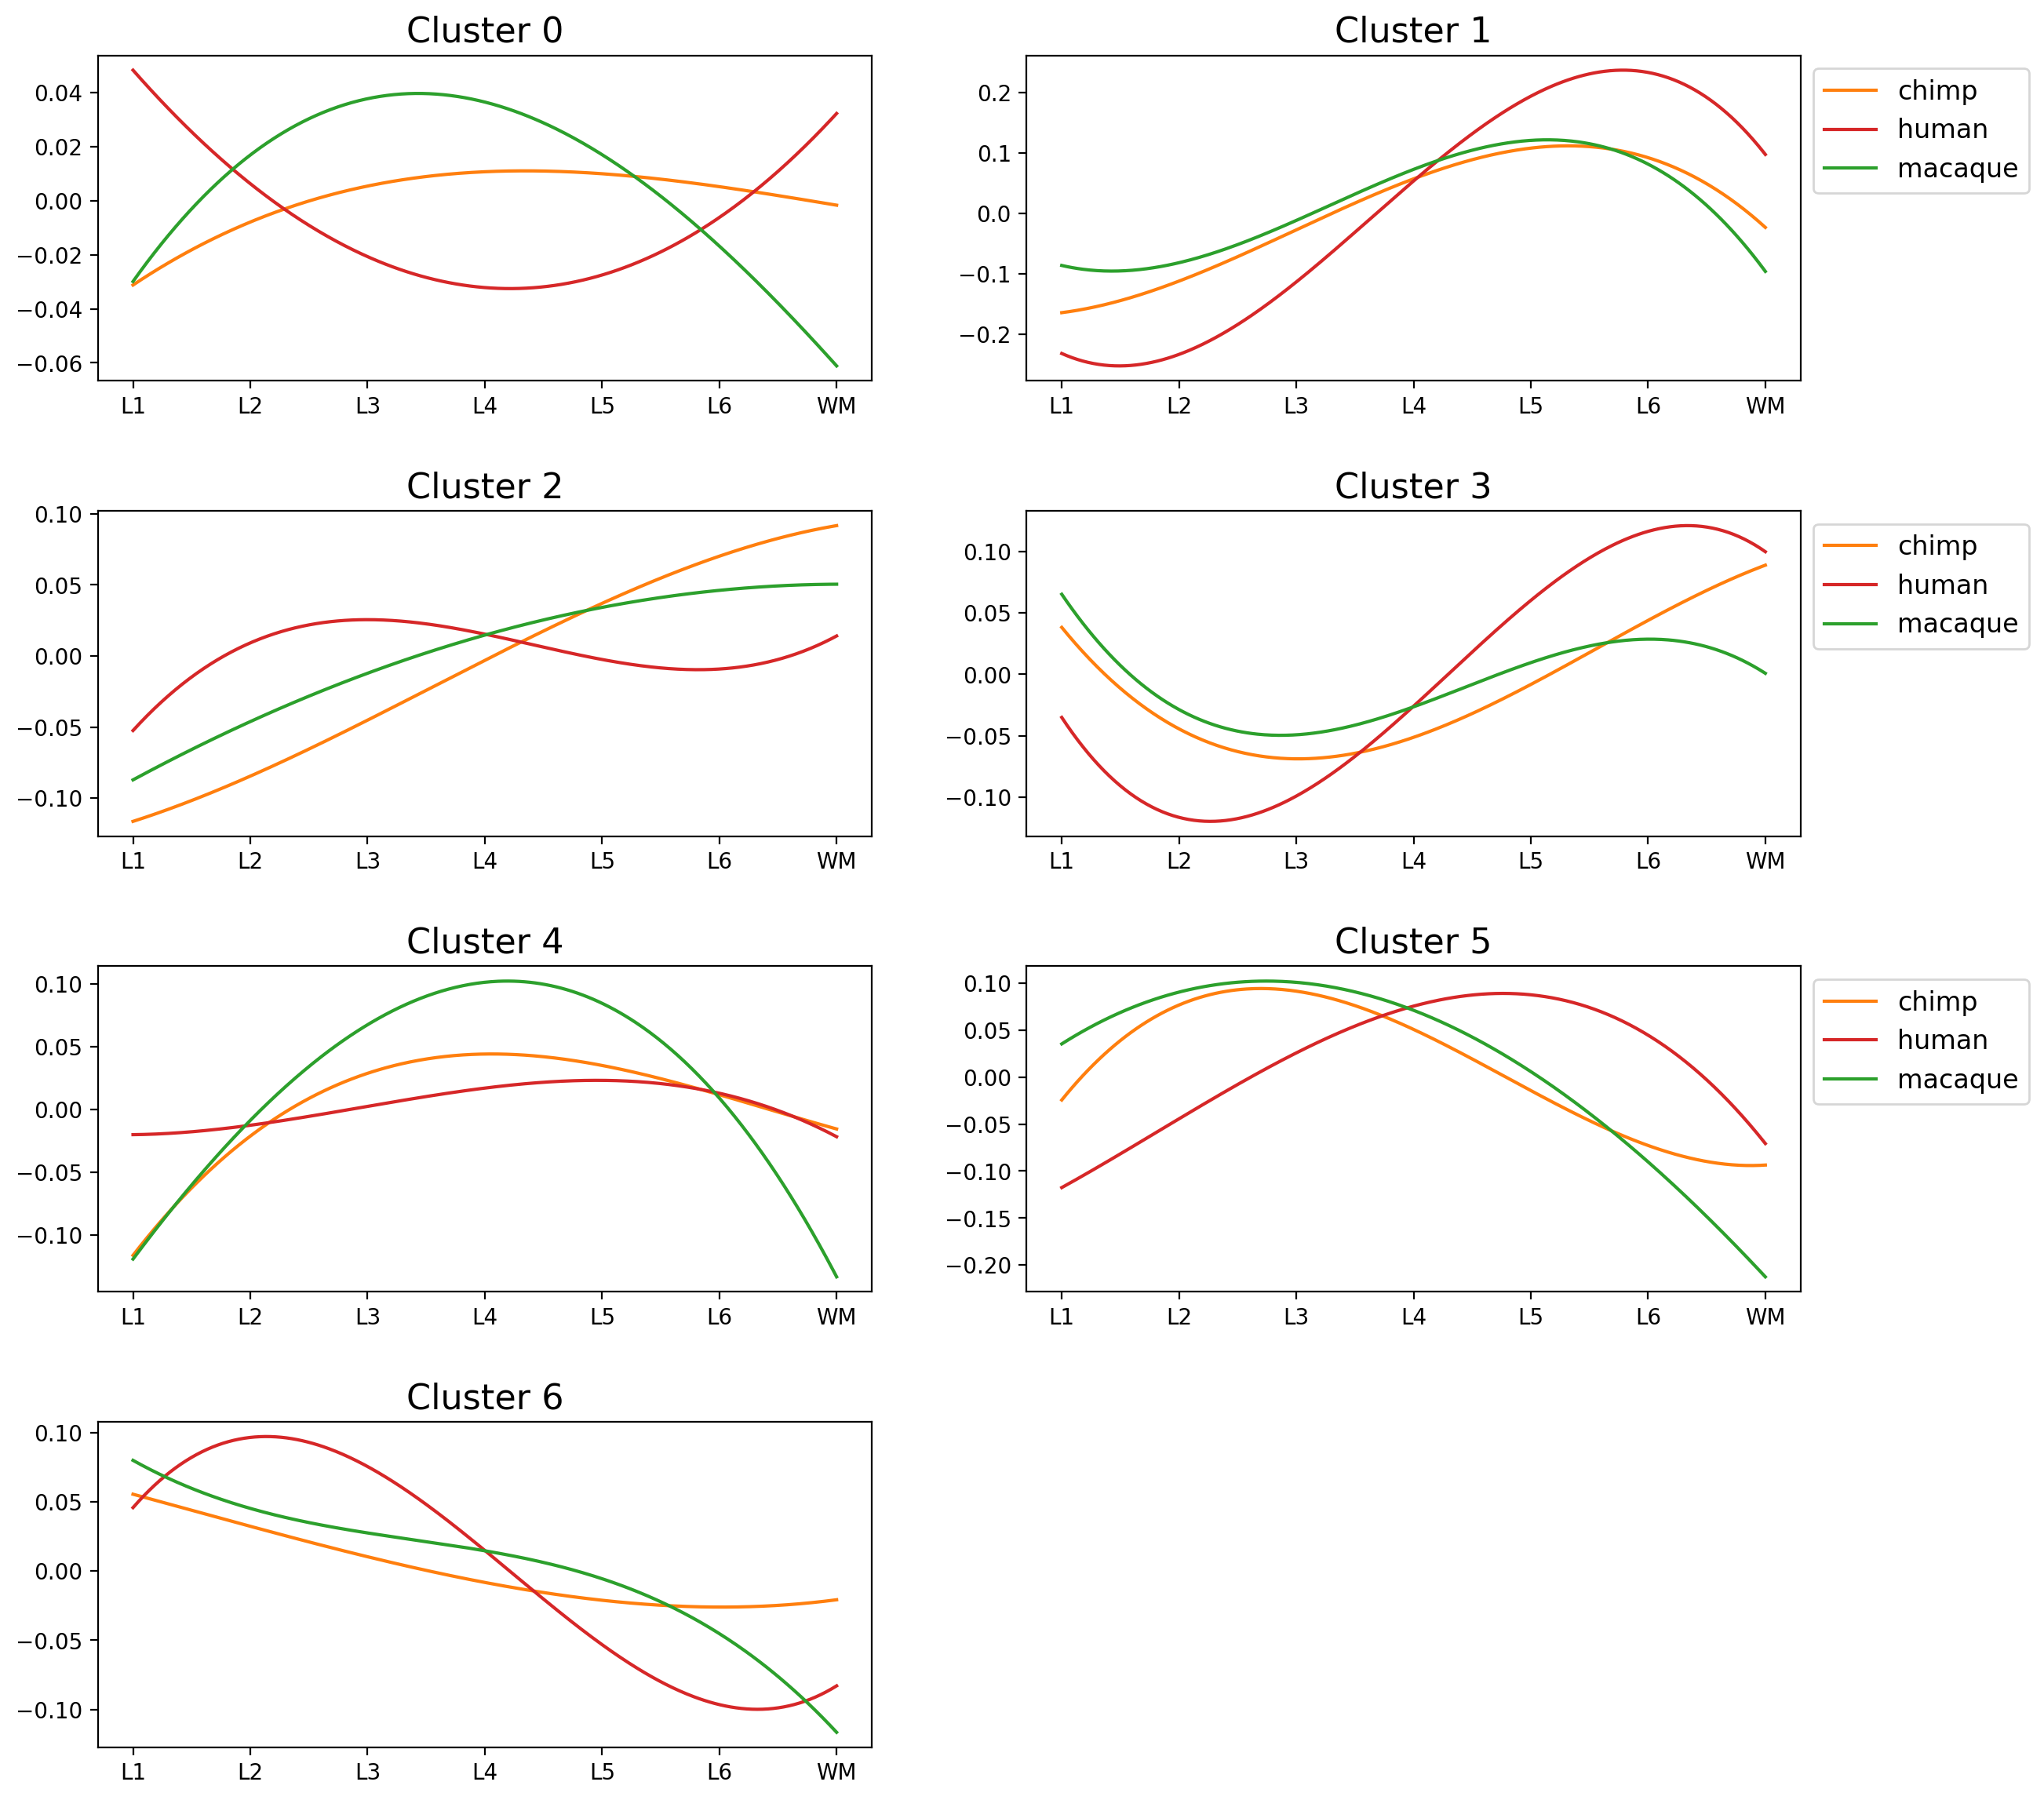

In [32]:
vis.plot_cluster_spline_profiles(
    grid,
    df_spline,
    labels,
    layers,
    specie_palette,
    n_clusters=None,
    figsize=(14, None),
    hspace=0.4,
    title_prefix="Cluster ",
)

plt.savefig(f'{figures_dir}/human_specific_genes_profiles_splines.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/human_specific_genes_profiles_splines.pdf', bbox_inches='tight')
plt.show()